# MLP Predictor for stock data

## Author: Danilo Filippo Reiszel Pereira
#### Univesidade Federal do Rio de Janeiro

#### This notebook contains the creation several Multi-layer Perceptron models to predict D+1 closing prices of stocks

In [1]:
from __future__ import print_function
import sys, os
sys.path.append('../../../../src') #neuralstocks directory
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.externals import joblib
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline

Using TensorFlow backend.


## Global Params

Setting global params such as directory of data, save directories and plot params

In [2]:
asset = 'ABEV3'
pathAsset = '../../../../../data/stocks/{}/diario/{}.CSV'.format(asset, asset)
pathIBOV = '../../../../../data/indexes/IBOV/diario/IBOV.CSV'
pathUSDBRL = '../../../../../data/forex/USDBRL/diario/USDBRL.CSV'

saveVarDir = './Variables'
os.makedirs(saveVarDir) if not os.path.exists(saveVarDir) else print('saveVarDir already exists')
saveFigDir = './Figures'
os.makedirs(saveFigDir) if not os.path.exists(saveFigDir) else print('saveFigDir already exists')
saveModelDir = './Models'
os.makedirs(saveModelDir) if not os.path.exists(saveModelDir) else print('saveModelDir already exists')

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

## Data Acquisition and Preprocessing

Gathers and preprocess data. Data from auxiliary time series (such as IBOV index and USDBRL exchange rate) is also gathered, though tipically less indicators are calculated for this series. Trend Extraction is applied to desired series.

<strong>List of indicators applied to main time series: </strong>
<ul>
    <li>Mean and Standard Deviation, 20 periods</li>
    <li>Returns Calculations:
        <ul>
            <li>Close<sub>d</sub> / Close<sub>d-1</sub></li>
            <li>Close<sub>d</sub> / Open<sub>d</sub></li>
            <li>High<sub>d</sub> / Close<sub>d</sub></li>
            <li>Low<sub>d</sub> / Close<sub>d</sub></li>
        </ul>
    </li>
    <li>EMAs:
        <ul>
            <li>Close, 17 periods</li>
            <li>Close, 72 periods</li>
            <li>Close, 200 periods</li>
            <li>Volume, 21 periods</li>
        </ul>
    </li>
    <li>MACD, fast EMA = 12 periods, slow EMA = 26 periods, signal EMA = 9 periods</li>
    <li>Bollinger Bands, 20 periods</li>
    <li>On-Balance Volume (OBV)</li>
</ul>

<strong>Parameters for trend extraction:</strong>
<ul>
    <li>Column: Close</li>
    <li>Decompose model: Additive</li>
    <li>Fitting Order: 1 (by default)</li>
    <li>Window Size: 6</li>
    <li>Fitting Weigths Model: Autocorrelation</li>
    <li>Fitting Weigths Model Window Size: 18</li>
</ul>

In [3]:
init_time = time.time()

ASSET = acquireData(filePath = pathAsset, dropNan = True)
IBOV = acquireData(filePath = pathIBOV, dropNan = True)
USDBRL= acquireData(filePath = pathUSDBRL, dropNan = True)
df = pd.concat([ASSET, IBOV, USDBRL], axis = 1).dropna()

end_time = time.time()

print('Time to acquire data: '+str(end_time-init_time)+' seconds')
print('Data samples from {} to {}'.format(df.index[0], df.index[-1]))

Time to acquire data: 0.112774848938 seconds
Data samples from 2000-12-19 00:00:00 to 2017-09-01 00:00:00


## Selection of wich features to feed the model

In [4]:
columnsToUse = ['{}_Close_resid', 
                '{}_Close_rollStd20', 
                '{}_Close_returns', '{}_Close/Open_returns', '{}_High/Close_returns', '{}_Low/Close_returns', 
                '{}_Close_EMA17_logdiff', '{}_Close_EMA72_logdiff', '{}_Close_EMA200_logdiff', '{}_Volume_EMA21_logdiff', 
                '{}_MACD_12_26_9', '{}_MACDsignal_12_26_9', '{}_Bollinger%b_20', '{}_OBV', 
                '{}_Holiday',
                'IBOV_Close_rollStd20', 
                'IBOV_Close_returns', 'IBOV_Close/Open_returns', 'IBOV_High/Close_returns', 'IBOV_Low/Close_returns',
                'IBOV_Close_EMA17_logdiff', 'IBOV_Close_EMA72_logdiff', 'IBOV_Close_EMA200_logdiff',
                'USDBRL_Close_rollStd20', 
                'USDBRL_Close_returns', 'USDBRL_Close/Open_returns', 'USDBRL_High/Close_returns', 'USDBRL_Low/Close_returns',
                'USDBRL_Close_EMA17_logdiff', 'USDBRL_Close_EMA72_logdiff', 'USDBRL_Close_EMA200_logdiff',
               ]
for i in range(len(columnsToUse)):
    columnsToUse[i] = columnsToUse[i].format(asset)

<h3>Creation of feature matrix and output array, split of data in Train and Test sets</h3>

In [5]:
xTrain, yTrain, xTest, yTest = prepData(df = df, columnsToUse = columnsToUse, 
                                                    columnToPredict = '{}_Close_resid'.format(asset), nDelays = 10, 
                                                    testSetSize = len(df['2017'])#, validationSplitSize = 0.15
                                                   )

print('Number of train samples: {}'.format(len(xTrain)))
#print('Number of validation samples: {}'.format(len(xVal)))
print('Number of test samples: {}'.format(len(xTest)))
print('Number of features per sample batch: {}'.format(len(xTrain[0])))

Number of train samples: 4174
Number of test samples: 175
Number of features per sample batch: 40


<h3>Feature Scalling</h3>

Technique used: Normalisation

In [6]:
xNormScaler = MinMaxScaler(feature_range = (-1,1))
xNormScaler.fit(xTrain)

yNormScaler = MinMaxScaler(feature_range = (-1,1))
yNormScaler.fit(yTrain)

xNormTrain = xNormScaler.transform(xTrain)
#xNormVal   = xNormScaler.transform(xVal)
xNormTest  = xNormScaler.transform(xTest)

yNormTrain = yNormScaler.transform(yTrain)
#yNormVal   = yNormScaler.transform(yVal)
yNormTest   = yNormScaler.transform(yTest)

<h3>Parameters for traning</h3>

In [7]:
inputDim = xTrain.shape[1]
nInits = 10 # number of times a topology will be trained
maxNeuronsInHiddenLayer = inputDim # upper limit for number of neurons in hidden layer

# optimizer definition
SGD = optimizers.SGD(lr=0.001, momentum=0.00, decay=0.0, nesterov=False)
ADAM = optimizers.Adam(lr=0.0001)

# callbacks definitions
earlyStopping = EarlyStopping(monitor='val_loss', patience=25, mode='auto')

<h3>Training of MLP model</h3>

In [8]:
init_time = time.time()

bestNormValLoss = np.Inf
bestNormFitHistory = None
bestNormHiddenLayer = 1
fitData = {}

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    fitData['{}_neurons'.format(nNeurons)] = {}
    modelCheckpoint = ModelCheckpoint('{}/{}_MLP_{}x{}x1_norm_mapminmax.h5'.format(saveModelDir, asset, inputDim, nNeurons), 
                                      save_best_only=True)
    for init in range(nInits):
        m_time = time.time()
        model = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                            Dense(1, activation = 'linear')
                           ])
        model.compile(optimizer = ADAM, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = model.fit(xNormTrain, 
                               yNormTrain, 
                               epochs = 2000,
                               verbose = 0,
                               shuffle = True,
                               validation_split = 0.15, 
                               callbacks = [modelCheckpoint,
                                            earlyStopping])
        fitData['{}_neurons'.format(nNeurons)]['{}_init_mse'.format(init+1)] = min(fitHistory.history['val_loss'])
        
        if min(fitHistory.history['val_loss']) < bestNormValLoss:
            name = '{}/{}_MLP_fitHistory_{}x{}x1_norm_mapminmax'.format(saveVarDir, asset, inputDim, nNeurons)
            bestNormValLoss = min(fitHistory.history['val_loss'])
            #bestNormFitHistory = fitHistory
            bestNormHiddenLayer = nNeurons
            joblib.dump(fitHistory.history, name + '.pkl')
        
        print('Fitted ({}, {}): {:.3f} seconds, RMSE {:.5f}'.format(nNeurons, init+1, time.time() - m_time, np.sqrt(min(fitHistory.history['val_loss']))), end = '\r')
        
end_time = time.time()
joblib.dump(fitData, '{}/{}_MLP_norm_mapminmax_fitdata.pkl'.format(saveVarDir, asset))
print('Time to fit all models: '+str(end_time-init_time)+' seconds')

Time to fit all models: 21337.8447838 seconds


In [9]:
print('Best model ({} inputs): {}x1'.format(inputDim, bestNormHiddenLayer))
bestNormModel = load_model('{}/{}_MLP_{}x{}x1_norm_mapminmax.h5'.format(saveModelDir, asset, inputDim, bestNormHiddenLayer))
bestNormModel.summary()

Best model (40 inputs): 35x1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_697 (Dense)            (None, 35)                1435      
_________________________________________________________________
dense_698 (Dense)            (None, 1)                 36        
Total params: 1,471
Trainable params: 1,471
Non-trainable params: 0
_________________________________________________________________


<h3>Plot of RMSE per epoch, for Training Set and Validation Set</h3>
Note: Validation set is not always the same as Test Set; it's randomly generated from the Training Set

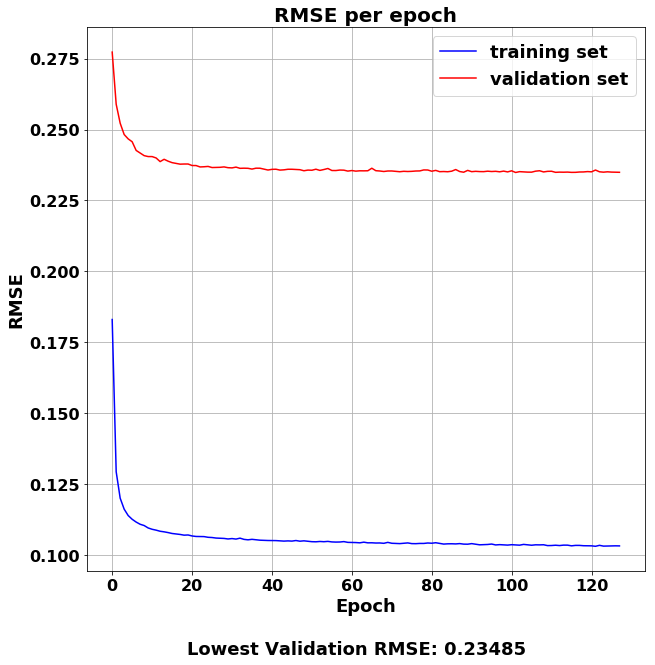

In [10]:
name = '{}/{}_MLP_fitHistory_{}x{}x1_norm_mapminmax'.format(saveVarDir, asset, inputDim, bestNormHiddenLayer)
bestNormFitHistory = joblib.load(name + '.pkl')
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.grid()
trainigSet, = ax.plot(np.sqrt(bestNormFitHistory['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestNormFitHistory['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 18})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {:.5f}'.format(np.sqrt(min(bestNormFitHistory['val_loss']))), size = 18, horizontalalignment = 'center')
fig.savefig('{}/{}_MLP_fitHistory_{}x{}x1_norm_mapminmax.pdf'.format(saveFigDir, asset, inputDim, bestNormHiddenLayer), bbox_inches='tight')

<h3>Plot of predictions made using the Test Set</h3>

(<matplotlib.figure.Figure at 0x7feaa11d4e50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feaa11f2110>)

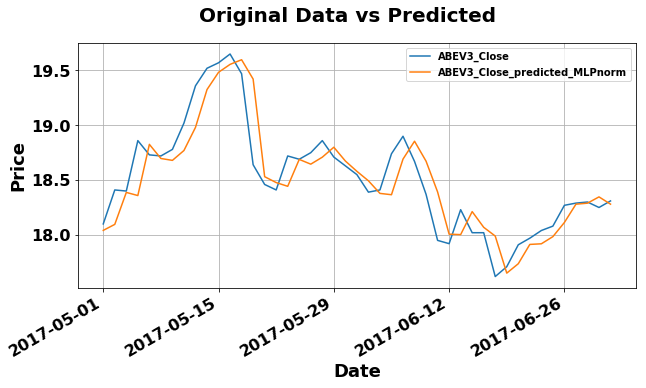

In [11]:
predictionsNorm = yNormScaler.inverse_transform(bestNormModel.predict(xNormTest)).reshape(-1)
predictionsNormResid = pd.Series(predictionsNorm, index = df['2017'].index, name = '{}_resid_predicted_MLPnorm'.format(asset))
predictionsNormSeries = pd.Series(df['{}_Close_trend'.format(asset)] +  predictionsNormResid, name = '{}_Close_predicted_MLPnorm'.format(asset))

plotSeries([df['{}_Close'.format(asset)], predictionsNormSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

<h3>Plot of errors from Trend Prediction and Trend + ANN Prediction</h3>

(<matplotlib.figure.Figure at 0x7feaa1548150>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feaa1522510>)

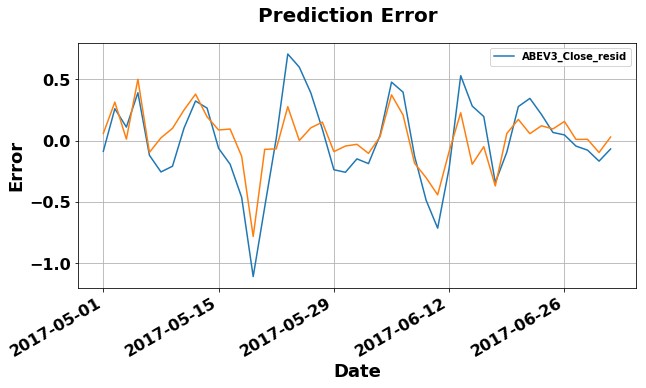

In [12]:
plotSeries([df['{}_Close_resid'.format(asset)], df['{}_Close'.format(asset)] - predictionsNormSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'Error')

In [13]:
df = pd.concat([df, predictionsNormResid, predictionsNormSeries], axis = 1)
df.to_csv('{}/{}_MLP_predicted.CSV'.format(saveVarDir, asset))

<h3>Retraining same topologies, but using standardization as scaling technique</h3>

In [14]:
xStdScaler = StandardScaler()
xStdScaler.fit(xTrain)

yStdScaler = StandardScaler()
yStdScaler.fit(yTrain)

xStdTrain = xStdScaler.transform(xTrain)
#xStdVal   = xStdScaler.transform(xVal)
xStdTest  = xStdScaler.transform(xTest)

yStdTrain = yStdScaler.transform(yTrain)
#yStdVal = yStdScaler.transform(yVal)
yStdTest = yStdScaler.transform(yTest)

In [15]:
init_time = time.time()

bestStdValLoss = np.Inf
bestStdFitHistory = None
bestStdHiddenLayer = 1

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpointStd = ModelCheckpoint('{}/{}_MLP_{}x{}x1_norm_mapstd.h5'.format(saveModelDir, asset, inputDim, nNeurons), 
                                      save_best_only=True)
    for init in range(nInits):
        m_time = time.time()
        modelStd = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                               Dense(1, activation = 'linear')
                              ])
        modelStd.compile(optimizer = ADAM, loss = 'mse', metrics = ['mae'])

        fitHistory = modelStd.fit(xStdTrain, 
                                  yStdTrain, 
                                  epochs = 2000,
                                  verbose = 0,
                                  shuffle = True,
                                  validation_split = 0.15, 
                                  callbacks = [modelCheckpointStd,
                                               earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestStdValLoss:
            name = '{}/{}_MLP_fitHistory_{}x{}x1_norm_mapstd'.format(saveVarDir, asset, inputDim, nNeurons)
            bestStdValLoss = min(fitHistory.history['val_loss'])
            #bestStdFitHistory = fitHistory
            bestStdHiddenLayer = nNeurons
            joblib.dump(fitHistory.history, name + '.pkl')
            
        print('Fitted ({}, {}): {:.3f} seconds, RMSE {:.5f}'.format(nNeurons, init+1, time.time() - m_time, np.sqrt(min(fitHistory.history['val_loss']))), end = '\r')

end_time = time.time()

print('Time to fit all models: '+str(end_time-init_time)+' seconds')

Time to fit all models: 54090.898757 seconds83


In [16]:
print('Best model ({} inputs): {}x1'.format(inputDim, bestStdHiddenLayer))
bestModelStd = load_model('{}/{}_MLP_{}x{}x1_norm_mapstd.h5'.format(saveModelDir, asset, inputDim, bestStdHiddenLayer))
bestModelStd.summary()

Best model (40 inputs): 2x1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_839 (Dense)            (None, 2)                 82        
_________________________________________________________________
dense_840 (Dense)            (None, 1)                 3         
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


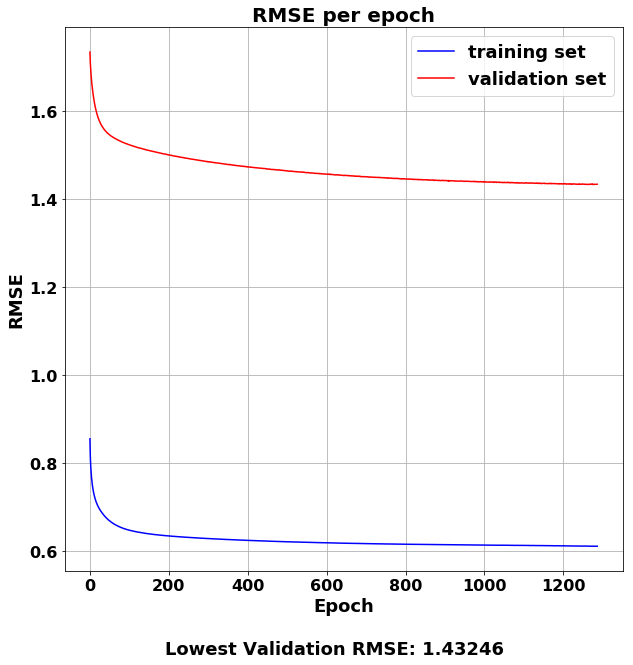

In [17]:
name = '{}/{}_MLP_fitHistory_{}x{}x1_norm_mapstd'.format(saveVarDir, asset, inputDim, bestStdHiddenLayer)
bestStdFitHistory = joblib.load(name + '.pkl')
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.grid()
trainigSet, = ax.plot(np.sqrt(bestStdFitHistory['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestStdFitHistory['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 18})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {:.5f}'.format(np.sqrt(min(bestStdFitHistory['val_loss']))), size = 18, horizontalalignment = 'center')
fig.savefig('{}/{}_MLP_fitHistory_{}x{}x1_norm_mapstd.pdf'.format(saveFigDir, asset, inputDim, bestStdHiddenLayer), bbox_inches='tight')

(<matplotlib.figure.Figure at 0x7fea639e9fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fea63b5d4d0>)

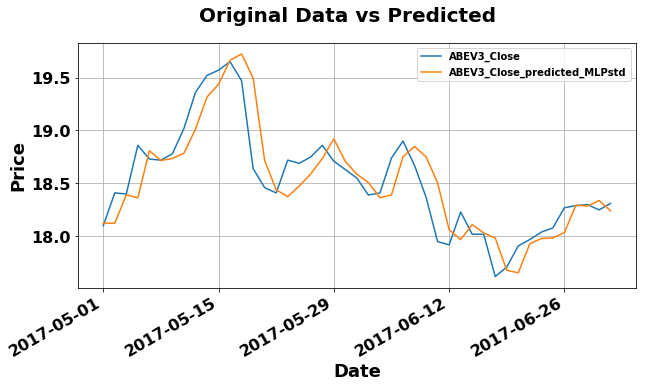

In [18]:
predictionsStd = yStdScaler.inverse_transform(bestModelStd.predict(xStdTest)).reshape(-1)
predictionsStdResid = pd.Series(predictionsStd, index = df['2017'].index, name = '{}_resid_predicted_MLPstd'.format(asset))
predictionsStdSeries = pd.Series(df['{}_Close_trend'.format(asset)] +  predictionsStdResid, name = '{}_Close_predicted_MLPstd'.format(asset))

plotSeries([df['{}_Close'.format(asset)], 
#            df['PETR4_Close_trend'],
            predictionsStdSeries],
#            predicted_PETR4_norm,
#            predicted_PETR4_mean],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

(<matplotlib.figure.Figure at 0x7fea639b63d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feaa150e1d0>)

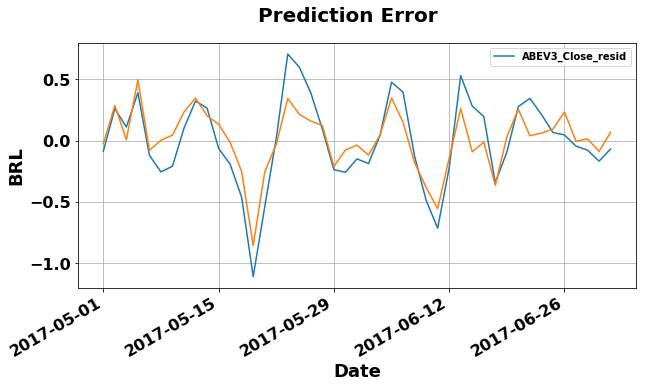

In [19]:
plotSeries([df['{}_Close_resid'.format(asset)], (df['{}_Close'.format(asset)] - predictionsStdSeries)],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')

In [20]:
df = pd.concat([df, predictionsStdResid, predictionsStdSeries], axis = 1)
df.to_csv('{}/{}_MLP_predicted.CSV'.format(saveVarDir, asset))

<h3>Retraining MLPs using only the delayed series as input, no auxiliar series, for comparative purposes</h3>

In [ ]:
xSimpleTrain, ySimpleTrain, xSimpleTest, ySimpleTest = prepData(df = df, 
                                                                columnsToUse = ['{}_Close_resid'.format(asset)], columnToPredict = '{}_Close_resid'.format(asset), 
                                                                nDelays = 10, testSetSize = len(df['2017']))

xSimpleScaler = MinMaxScaler(feature_range = (-1,1))
xSimpleScaler.fit(xSimpleTrain)

ySimpleScaler = MinMaxScaler(feature_range = (-1,1))
ySimpleScaler.fit(ySimpleTrain)

xSimpleTrain = xSimpleScaler.transform(xSimpleTrain)
#xSimpleVal   = xSimpleScaler.transform(xSimpleVal)
xSimpleTest  = xSimpleScaler.transform(xSimpleTest)

ySimpleTrain = ySimpleScaler.transform(ySimpleTrain)
#ySimpleVal   = ySimpleScaler.transform(ySimpleVal)
ySimpleTest  = ySimpleScaler.transform(ySimpleTest)

In [ ]:
inputDim = xSimpleTrain.shape[1]

maxNeuronsInHiddenLayer = inputDim # upper limit for number of neurons in hidden layer

bestSimpleValLoss = np.Inf
bestSimpleFitHistory = None
bestSimpleHiddenLayer = 1

init_time = time.time()

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpointSimple = ModelCheckpoint('{}/{}_MLP_{}x{}x1_norm_mapminmax.h5'.format(saveModelDir, asset, inputDim, nNeurons), 
                                            save_best_only=True)
    for init in range(nInits):
        m_time = time.time()
        modelSimple = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                                  Dense(1, activation = 'linear')
                                 ])
        modelSimple.compile(optimizer = ADAM, loss = 'mse', metrics = ['mae'])

        fitHistory = modelSimple.fit(xSimpleTrain, 
                                     ySimpleTrain, 
                                     epochs = 2000,
                                     verbose = 0,
                                     shuffle = True,
                                     validation_split = 0.15, 
                                     callbacks = [modelCheckpointSimple,
                                                  earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestSimpleValLoss:
            name = '{}/{}_MLP_fitHistory_{}x{}x1_norm_mapminmax'.format(saveVarDir, asset, inputDim, nNeurons)
            bestSimpleValLoss = min(fitHistory.history['val_loss'])
            #bestSimpleFitHistory = fitHistory
            bestSimpleHiddenLayer = nNeurons
            joblib.dump(fitHistory.history, name + '.pkl')
            
        print('Fitted ({}, {}): {:.3f} seconds, RMSE {:.5f}'.format(nNeurons, init+1, time.time() - m_time, np.sqrt(min(fitHistory.history['val_loss']))), end = '\r')

end_time = time.time()

print('Time to fit all models: '+str(end_time-init_time)+' seconds')

In [ ]:
print('Best model ({} inputs): {}x1'.format(inputDim, bestSimpleHiddenLayer))
bestModelSimple = load_model('{}/{}_MLP_{}x{}x1_norm_mapminmax.h5'.format(saveModelDir, asset, inputDim, bestSimpleHiddenLayer))
bestModelSimple.summary()

In [ ]:
name = '{}/{}_MLP_fitHistory_{}x{}x1_norm_mapminmax'.format(saveVarDir, asset, inputDim, bestSimpleHiddenLayer)
bestSimpleFitHistory = joblib.load(name + '.pkl')
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestSimpleFitHistory['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestSimpleFitHistory['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(bestSimpleFitHistory['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}_MLP_fitHistory_{}x{}x1_norm_mapminmax.pdf'.format(saveFigDir, asset, inputDim, bestSimpleHiddenLayer), bbox_inches='tight')

In [ ]:
predictionsSimple = ySimpleScaler.inverse_transform(bestModelSimple.predict(xSimpleTest)).reshape(-1)
predictionsSimpleResid = pd.Series(predictionsSimple, index = df['2017'].index, name = '{}_resid_predicted_minmax_s'.format(asset))
predictionsSimpleSeries = pd.Series(df['{}_Close_trend'.format(asset)] +  predictionsSimpleResid, name = '{}_Close_predicted_minmax_s'.format(asset))

plotSeries([df['{}_Close'.format(asset)], 
#            df['PETR4_Close_trend'],
            predictionsSimpleSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

In [ ]:
plotSeries([df['{}_Close_resid'.format(asset)], (df['{}_Close'.format(asset)] - predictionsSimpleSeries)],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'BRL')

<h3>Retraining MLPs using only the delayed series as input, no auxiliar series, and StandardScaler</h3>

In [ ]:
xSimpleStdScaler = StandardScaler()
xSimpleStdScaler.fit(xSimpleTrain)

ySimpleStdScaler = StandardScaler()
ySimpleStdScaler.fit(ySimpleTrain)

xSimpleStdTrain = xSimpleStdScaler.transform(xSimpleTrain)
#xSimpleStdVal   = xSimpleStdScaler.transform(xSimpleVal)
xSimpleStdTest  = xSimpleStdScaler.transform(xSimpleTest)

ySimpleStdTrain = ySimpleStdScaler.transform(ySimpleTrain)
#ySimpleStdVal   = ySimpleStdScaler.transform(ySimpleVal)
ySimpleStdTest  = ySimpleStdScaler.transform(ySimpleTest)

In [ ]:
inputDim = xSimpleTrain.shape[1]

maxNeuronsInHiddenLayer = 10 # upper limit for number of neurons in hidden layer

bestSimpleStdValLoss = np.Inf
bestSimpleStdFitHistory = None
bestSimpleStdHiddenLayer = 1

init_time = time.time()

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpointSimpleStd = ModelCheckpoint('{}/{}_MLP_{}x{}x1_norm_mapstd.h5'.format(saveModelDir, asset inputDim, nNeurons), 
                                          save_best_only=True)
    for init in range(nInits):
        m_time = time.time()
        modelSimpleStd = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                                     Dense(1, activation = 'linear')
                                    ])
        modelSimpleStd.compile(optimizer = ADAM, loss = 'mean_squared_error', metrics = ['mae'])

        fitHistory = modelSimpleStd.fit(xSimpleStdTrain, 
                                     ySimpleStdTrain, 
                                     epochs = 2000,
                                     verbose = 0,
                                     shuffle = True,
                                     validation_split = 0.15, 
                                     callbacks = [modelCheckpointSimpleStd,
                                                  earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestSimpleStdValLoss:
            name = '{}/{}_MLP_fitHistory_{}x{}x1_norm_mapstd'.format(saveVarDir, asset, inputDim, nNeurons)
            bestSimpleStdValLoss = min(fitHistory.history['val_loss'])
            #bestSimpleStdFitHistory = fitHistory
            bestSimpleStdHiddenLayer = nNeurons
            joblib.dump(fitHistory.history, name + '.pkl')
            
        print('Fitted ({}, {}): {:.3f} seconds, RMSE {:.5f}'.format(nNeurons, init+1, time.time() - m_time, np.sqrt(min(fitHistory.history['val_loss']))), end = '\r')

end_time = time.time()

print('Time to fit all models: '+str(end_time-init_time)+' seconds')

In [ ]:
print('Best model ({} inputs): {}x1'.format(inputDim, bestSimpleStdHiddenLayer))
bestModelSimpleStd = load_model('{}/{}_MLP_{}x{}x1_norm_mapstd.h5'.format(saveModelDir, asset, inputDim, bestSimpleStdHiddenLayer))
bestModelSimpleStd.summary()

In [ ]:
name = '{}/{}_MLP_fitHistory_{}x{}x1_norm_mapstd'.format(saveVarDir, asset, inputDim, bestSimpleStdHiddenLayer)
bestSimpleStdFitHistory = joblib.load(name + '.pkl')
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainingSet, = ax.plot(np.sqrt(bestSimpleStdFitHistory['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestSimpleStdFitHistory['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainingSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(bestSimpleStdFitHistory['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}_MLP_fitHistory_{}x{}x1_norm_mapminmax.pdf'.format(saveFigDir, asset, inputDim, bestSimpleStdHiddenLayer), bbox_inches='tight')

In [ ]:
predictionsSimpleStd = ySimpleStdScaler.inverse_transform(bestModelSimpleStd.predict(xSimpleStdTest)).reshape(-1)
predictionsSimpleStdResid = pd.Series(predictionsSimpleStd, index = df['2017'].index, name = '{}_resid_predicted_std_s'.format(asset))
predictionsSimpleStdSeries = pd.Series(df['{}_Close_trend'.format(asset)] +  predictionsSimpleStdResid, name = '{}_Close_predicted_std_s'.format(asset))

plotSeries([df['{}_Close'.format(asset)], 
#            df['PETR4_Close_trend'],
            predictionsSimpleStdSeries],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Original Data vs Predicted', ylabel = 'Price')

In [ ]:
plotSeries([df['{}_Close_resid'.format(asset)], (df['{}_Close'.format(asset)] - predictionsSimpleStdSeries)],
           initialPlotDate = '2017-05', finalPlotDate = '2017-06',
           title = 'Prediction Error', ylabel = 'Error')